## Predicting Data Contribution of Minecraft Players Using Player Characteristics

### 1. Introduction

#### 1.1 Background

#### 1.2 Research Question
We would like to know which "kinds" of players are most likely to contribute a large amount of data so that we can target those players in our recruiting efforts.

Can player characteristics such as age, experience, and gender predict the amount of data (measured in total played hours) a player contributes?

### 2. Data Description

In [2]:
library(tidyverse)
library(repr)
library(dplyr)
library(tidyclust)
library(tidymodels)
library(recipes)

set.seed(5)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard()           masks purrr::discard()
✖ d

Data description

A csv file called `players.csv` is used which contains data of all unique Minecraft players including the following variables:

- `experience`:
- `subscribe`:
- `hashedEmail`:
- `played_hours`:
- `name`:
- `gender`:
- `Age`:
(add data type as well)

There are total of 196 observations and 7 variables.

summary stats

issues: experience and gender should be factor type, `hashedEmail`, `name` variables are unnecessary, has missing datas represented as FALSE
gender other than male and female will be renamed as other since there are not enough number for each non male/female gender

how the data was collected?

In [43]:
players_data <- read_csv("data/players.csv")

# preview of the data file players
head(players)
head(is.na(players))

# to see all unique values present in variables with factor type
players_data |> distinct(experience)
players_data |> distinct(gender)

gender_prop <- players_data |>
                group_by(gender) |>
                summarize(count = n())
gender_prop

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


experience,played_hours,gender,Age
<fct>,<dbl>,<fct>,<dbl>
Pro,30.3,Male,9
Veteran,3.8,Male,17
Amateur,0.7,Female,21
Regular,0.1,Male,21
Amateur,0.1,Male,17
Veteran,1.6,Female,23


experience,played_hours,gender,Age
FALSE,FALSE,FALSE,FALSE
FALSE,FALSE,FALSE,FALSE
FALSE,FALSE,FALSE,FALSE
FALSE,FALSE,FALSE,FALSE
FALSE,FALSE,FALSE,FALSE
FALSE,FALSE,FALSE,FALSE


experience
<chr>
Pro
Veteran
Amateur
Regular
Beginner


gender
<chr>
Male
Female
Non-binary
Prefer not to say
Agender
Two-Spirited
Other


gender,count
<chr>,<int>
Agender,2
Female,37
Male,124
Non-binary,15
Other,1
Prefer not to say,11
Two-Spirited,6


### 3. Methods and Results

#### 3.1 Data Cleaning

Remove unnecessary columns, remove observations that contain NA, convert experience and gender data type to factor type.
Since the gender other than Male and Female is scarce, combine them into Other (non-binary, two-spirited etc). How I did this > from the wrangled players data, I filtered to only have non male non female gender. then use mutate function to name all of them into Other.  Then create a df with only male and female. Combine the two df that has other gender and df that has male and female. compare the gender_prop_clean1 whichc is just after removeing na values and gender_prop_clean2 after renameing other. The number adds up.

In [90]:
# data wrangling

players <- players_data |>
                select(-subscribe, -hashedEmail, -name) |>
                filter(experience != is.na(experience), played_hours != is.na(played_hours), 
                        gender != is.na(gender), Age != is.na(Age)) |>
                mutate(experience = as_factor(experience))

# turn gender other than Male and Female into other
other_gender <- players |>
                filter(gender != "Male" & gender != "Female") |>
                mutate(gender = "Other")

# clean data with only male and female
male_female <- players |>
                filter(gender %in% c("Male", "Female")) 

# combine df with only male and female, and df with only other 
players_clean <- bind_rows(male_female, other_gender) |>
                mutate(gender = as_factor(gender)) 
 
head(players_clean)
head(male_female)

gender_prop_clean1 <- players |>
                group_by(gender) |>
                summarize(count = n())

gender_prop_clean1

# gender proportion after cleaning up data
gender_prop_clean2 <- players_clean |>
                group_by(gender) |>
                summarize(count = n())

gender_prop_clean2

experience,played_hours,gender,Age
<fct>,<dbl>,<fct>,<dbl>
Pro,30.3,Male,9
Veteran,3.8,Male,17
Amateur,0.7,Female,21
Regular,0.1,Male,21
Amateur,0.1,Male,17
Veteran,1.6,Female,23


experience,played_hours,gender,Age
<fct>,<dbl>,<chr>,<dbl>
Pro,30.3,Male,9
Veteran,3.8,Male,17
Amateur,0.7,Female,21
Regular,0.1,Male,21
Amateur,0.1,Male,17
Veteran,1.6,Female,23


gender,count
<chr>,<int>
Agender,1
Female,21
Male,75
Non-binary,6
Prefer not to say,5
Two-Spirited,1


gender,count
<fct>,<int>
Male,75
Female,21
Other,13


#### 3.2 Exploratory Data Analysis (EDA)

##### 3.2.1 Summary of Variables
Proportion of gender and experience calculated - categorical variable, and summary stats for played hours and age - numerical variables

In [91]:
num_obs <- nrow(players_clean)

# experience proportion
experience_pro <- players_clean |>
                group_by(experience) |>
                summarize(count = n(),
                          percentage = n() / num_obs * 100)

experience_pro

# gender proportion
gender_prop <- players_clean |>
                group_by(gender) |>
                summarize(count = n(),
                          percentage = n() / num_obs * 100)
gender_prop

# played hours summary statistic
played_hours_stat <- players_clean |>
                    summarize(mean = mean(played_hours),
                              median = median(played_hours),
                              min = min(played_hours),
                              max = max(played_hours),
                              SD = sd(played_hours))
played_hours_stat

# age summary statistic
age_stat <- players_clean |>
            summarize(mean = mean(Age),
                      median = median(Age),
                      min = min(Age),
                      max = max(Age),
                      SD = sd(Age))
age_stat

# mean played hours by gender
mean_hours_gender <- players_clean |>
                    group_by(gender) |>
                    summarize(mean_played_hours = mean(played_hours))
mean_hours_gender

# mean played hours by experience
mean_hours_experience <- players_clean |>
                    group_by(experience) |>
                    summarize(mean_played_hours = mean(played_hours))
mean_hours_experience

experience,count,percentage
<fct>,<int>,<dbl>
Pro,10,9.174312
Veteran,26,23.853211
Amateur,35,32.110092
Regular,19,17.431193
Beginner,19,17.431193


gender,count,percentage
<fct>,<int>,<dbl>
Male,75,68.80734
Female,21,19.26606
Other,13,11.92661


mean,median,min,max,SD
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
10.50917,0.5,0.1,223.1,37.4496


mean,median,min,max,SD
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
20.56881,19,8,49,6.422425


gender,mean_played_hours
<fct>,<dbl>
Male,6.82400
Female,18.73810
Other,18.47692


experience,mean_played_hours
<fct>,<dbl>
Pro,3.620000
Veteran,1.196154
Amateur,10.831429
Regular,34.494737
Beginner,2.300000


##### 3.2.2 Plots for EDA

Scatter plot : age vs played_hours color with gender and experience separately - facet_grid. Insights etc

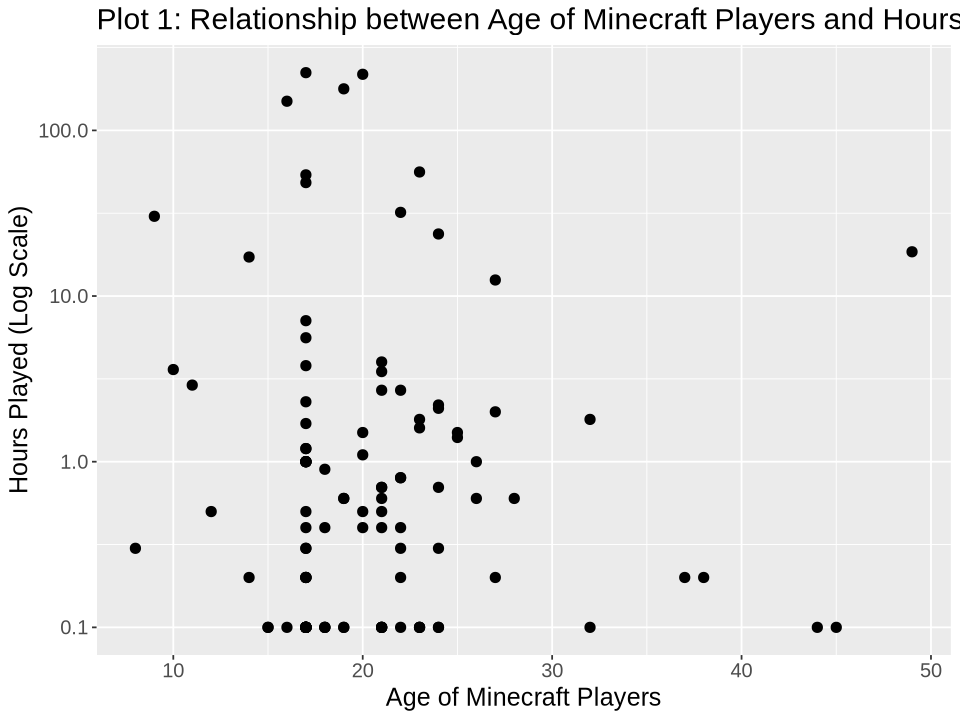

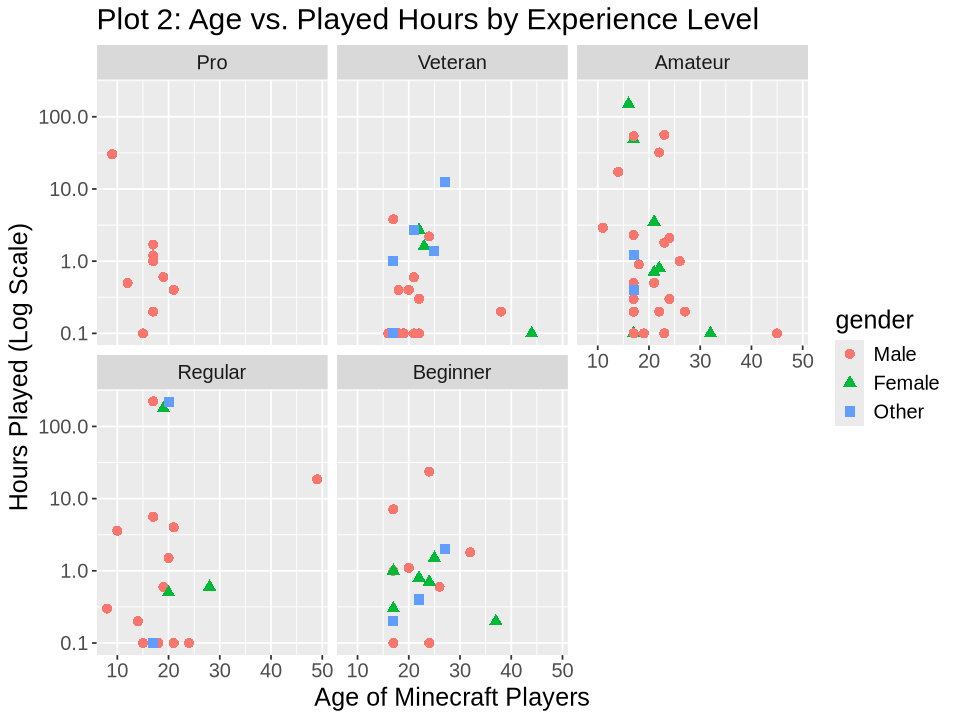

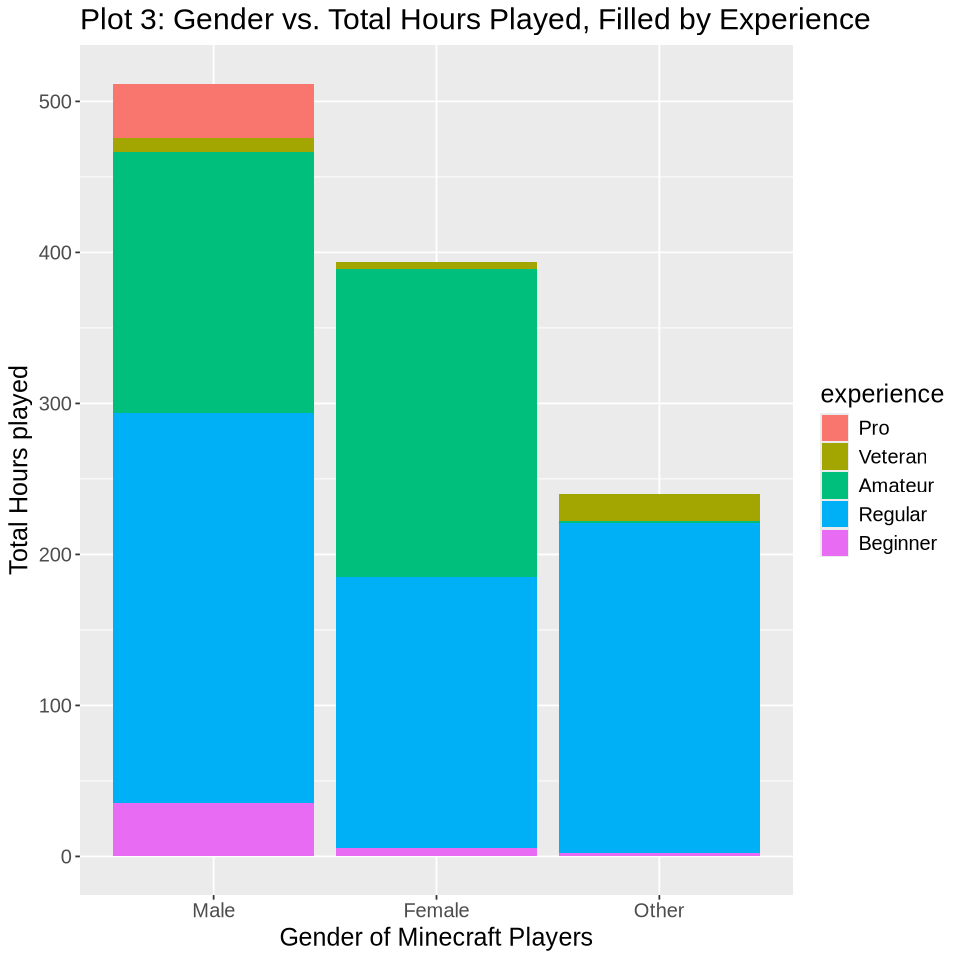

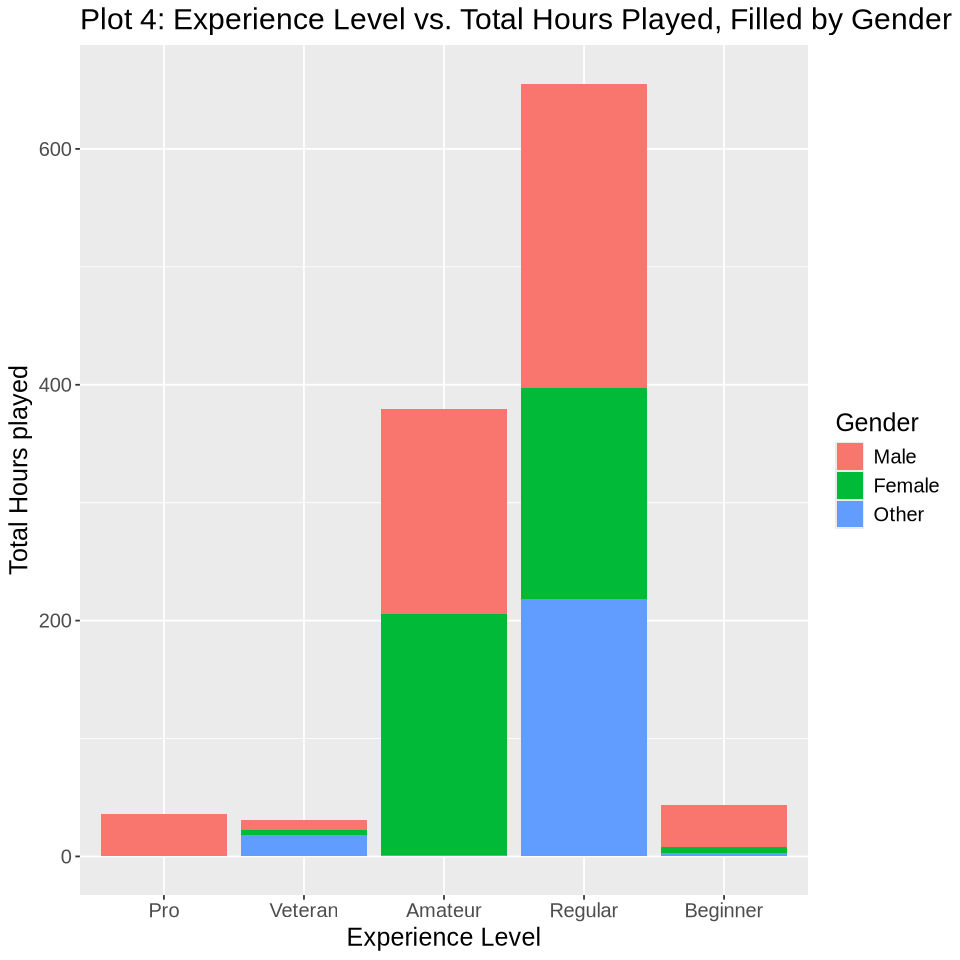

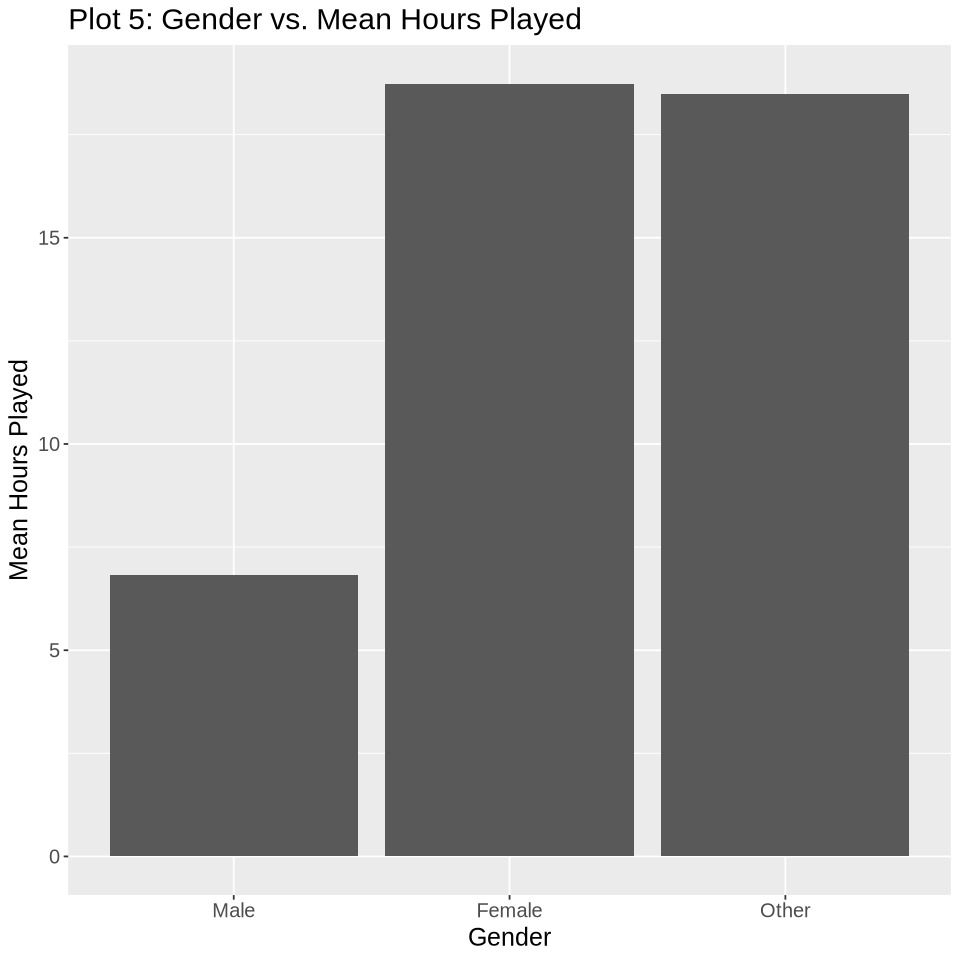

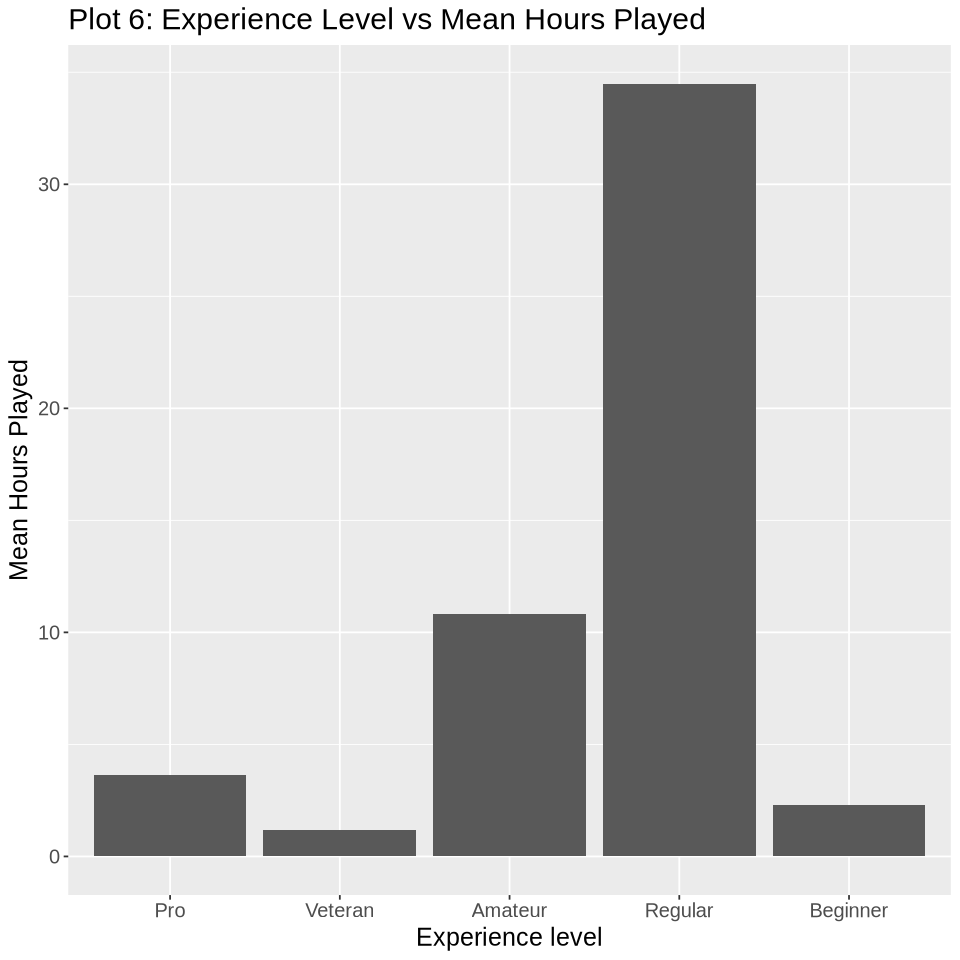

In [119]:
options(repr.plot.width = 8, repr.plot.height = 6)
age_vs_hrs_1 <- players_clean |>
                ggplot(aes(x = Age, y = played_hours)) +
                geom_point(size = 2.5) +
                labs(x = "Age of Minecraft Players",
                     y = "Hours Played (Log Scale)") +
                scale_y_log10() +
                theme(text = element_text(size = 15)) + 
                ggtitle("Plot 1: Relationship between Age of Minecraft Players and Hours Played")

age_vs_hrs_1

age_vs_hrs_2 <- players_clean |>
                ggplot(aes(x = Age, y = played_hours, color = gender, shape = gender)) +
                geom_point(size = 2.5) +
                labs(x = "Age of Minecraft Players",
                     y = "Hours Played (Log Scale)") +
                scale_y_log10() +
                theme(text = element_text(size = 15)) +
                facet_wrap(~experience) +
                ggtitle("Plot 2: Age vs. Played Hours by Experience Level")

age_vs_hrs_2 

options(repr.plot.width = 8, repr.plot.height = 8)
gender_vs_hrs <- players_clean |>
    ggplot(aes(x = gender, y = played_hours, fill = experience)) +
           geom_bar(stat = "identity") +
           xlab("Gender of Minecraft Players") +
           ylab("Total Hours played") +
           ggtitle("Plot 3: Gender vs. Total Hours Played, Filled by Experience") +
           theme(text = element_text(size = 15))

gender_vs_hrs

exp_vs_hrs <- players_clean |>
    ggplot(aes(x = experience, y = played_hours, fill = gender)) +
           geom_bar(stat = "identity") +
           xlab("Experience Level") +
           ylab("Total Hours played") +
           labs(fill = "Gender", title = "Plot 4: Experience Level vs. Total Hours Played, Filled by Gender") +
           theme(text = element_text(size = 15))
exp_vs_hrs

gender_vs_mean_hrs <- mean_hours_gender |>
    ggplot(aes(x = gender, y = mean_played_hours)) +
           geom_bar(stat = "identity") +
           xlab("Gender") +
           ylab("Mean Hours Played") +
           ggtitle("Plot 5: Gender vs. Mean Hours Played") +
           theme(text = element_text(size = 15))
gender_vs_mean_hrs

exp_vs_mean_hrs <- mean_hours_experience |>
    ggplot(aes(x = experience, y = mean_played_hours)) +
           geom_bar(stat = "identity") +
           xlab("Experience level") +
           ylab("Mean Hours Played") +
           ggtitle("Plot 6: Experience Level vs Mean Hours Played") +
           theme(text = element_text(size = 15))
exp_vs_mean_hrs

###

#### 3.3 Modeling

In [133]:
# K-means recipe
kmeans_recipe <- recipe(~ Age + played_hours, data = players_clean) |>
                step_scale(all_predictors()) |>
                step_center(all_predictors())

# choosing num of k 
k_vals <- tibble(num_clusters = 1:10)

kmeans_spec_tune <- k_means(num_clusters = tune()) |>
                set_engine("stats", nstart = 10) 

kmeans_results <- workflow() |>
                add_recipe(kmeans_recipe) |>
                add_model(kmeans_spec_tune) |>
                tune_cluster(resamples = apparent(players_clean), grid = k_vals) |>
                collect_metrics() |>
                filter(.metric == "sse_within_total") |>
                mutate(total_WSSD = mean) |>
                select(num_clusters, total_WSSD)
kmeans_results

num_clusters,total_WSSD
<int>,<dbl>
1,216.000000
2,117.435042
3,52.449347
4,28.279096
5,22.563024
6,17.312064
7,12.229168
8,11.259075
9,8.068990


Choose K = 4 as this is wehre the WSSD decrease most form prev poitn but after this small reduce from now on. It is the elbow

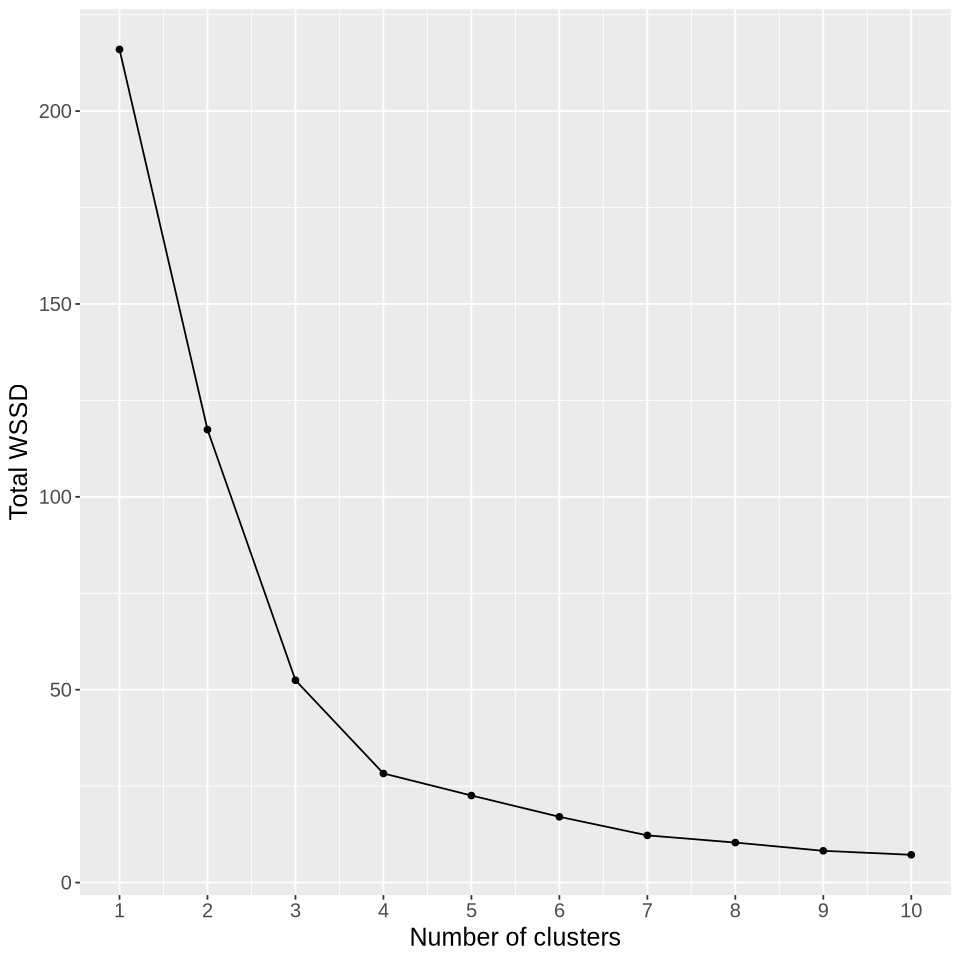

In [132]:
elbow_plot <- kmeans_results |>
            ggplot(aes(x = num_clusters, y = total_WSSD)) +
            geom_point() +
            geom_line() +
            xlab("Number of clusters") +
            ylab("Total WSSD") +
            theme(text = element_text(size = 15)) +
            scale_x_continuous(breaks = 1:10)
elbow_plot

In [136]:
# reset model with chosen K
kmeans_spec <- k_means(num_clusters = 4) |>
            set_engine("stats", nstart = 10)

# fit the model
kmeans_fit <- workflow() |>
            add_recipe(kmeans_recipe) |>
            add_model(kmeans_spec) |>
            fit(players_clean)

# augment original data frame with cluster assignments 
clustered_data <- kmeans_fit |>
                augment(players_clean) 

head(clustered_data)

.pred_cluster,experience,played_hours,gender,Age
<fct>,<fct>,<dbl>,<fct>,<dbl>
Cluster_1,Pro,30.3,Male,9
Cluster_1,Veteran,3.8,Male,17
Cluster_2,Amateur,0.7,Female,21
Cluster_2,Regular,0.1,Male,21
Cluster_1,Amateur,0.1,Male,17
Cluster_2,Veteran,1.6,Female,23


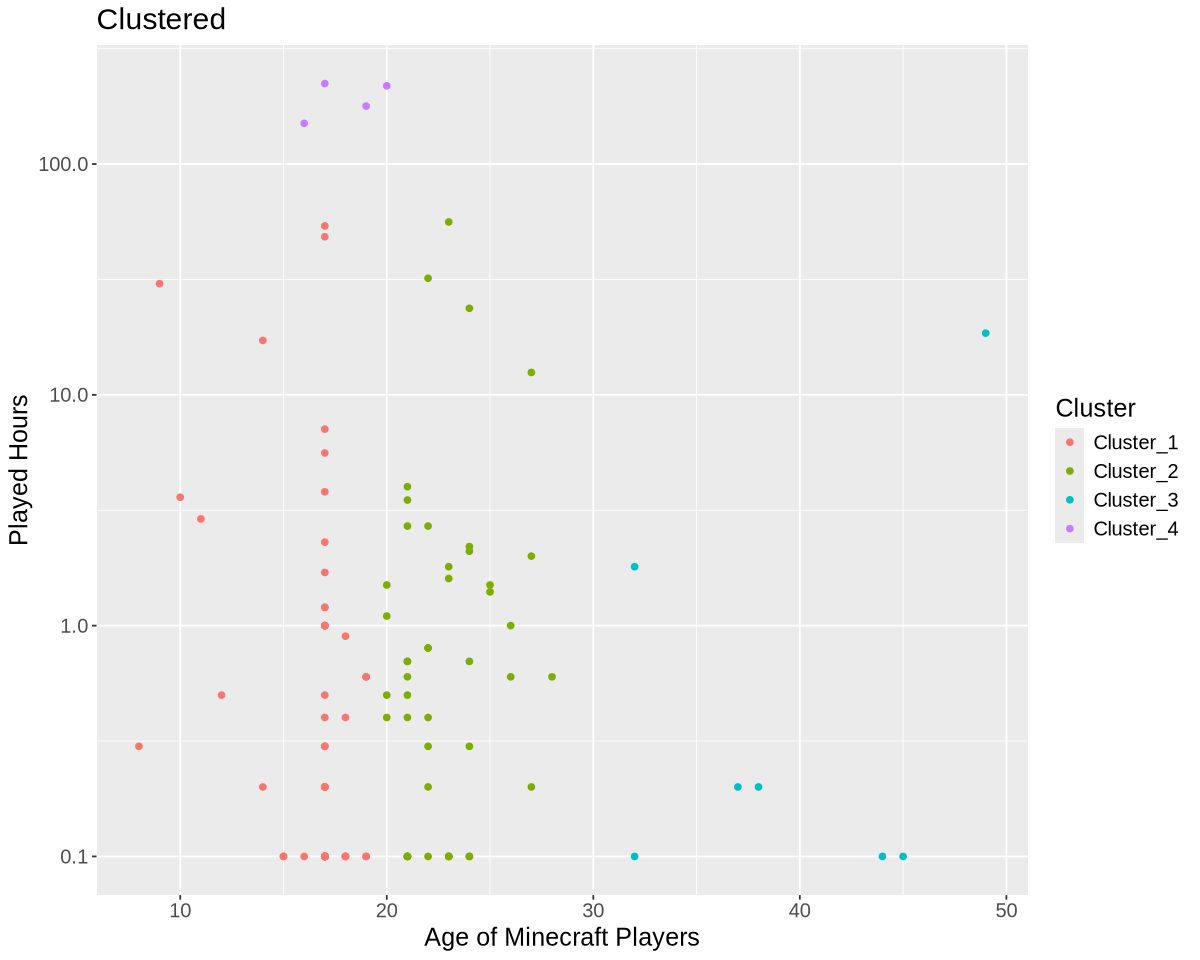

In [139]:
# plot clustered data
options(repr.plot.width = 10, repr.plot.height = 8)
clustered_plot <- clustered_data |>
                ggplot(aes(x = Age, y = played_hours, color = .pred_cluster)) +
                geom_point() +
                labs(x = "Age of Minecraft Players", 
                     y = "Played Hours",
                     color = "Cluster",
                     title = "Clustered") +
                theme(text = element_text(size = 15)) +
                scale_y_log10()

clustered_plot

`summarise()` has grouped output by '.pred_cluster'. You can override using the
`.groups` argument.
`summarise()` has grouped output by '.pred_cluster'. You can override using the
`.groups` argument.


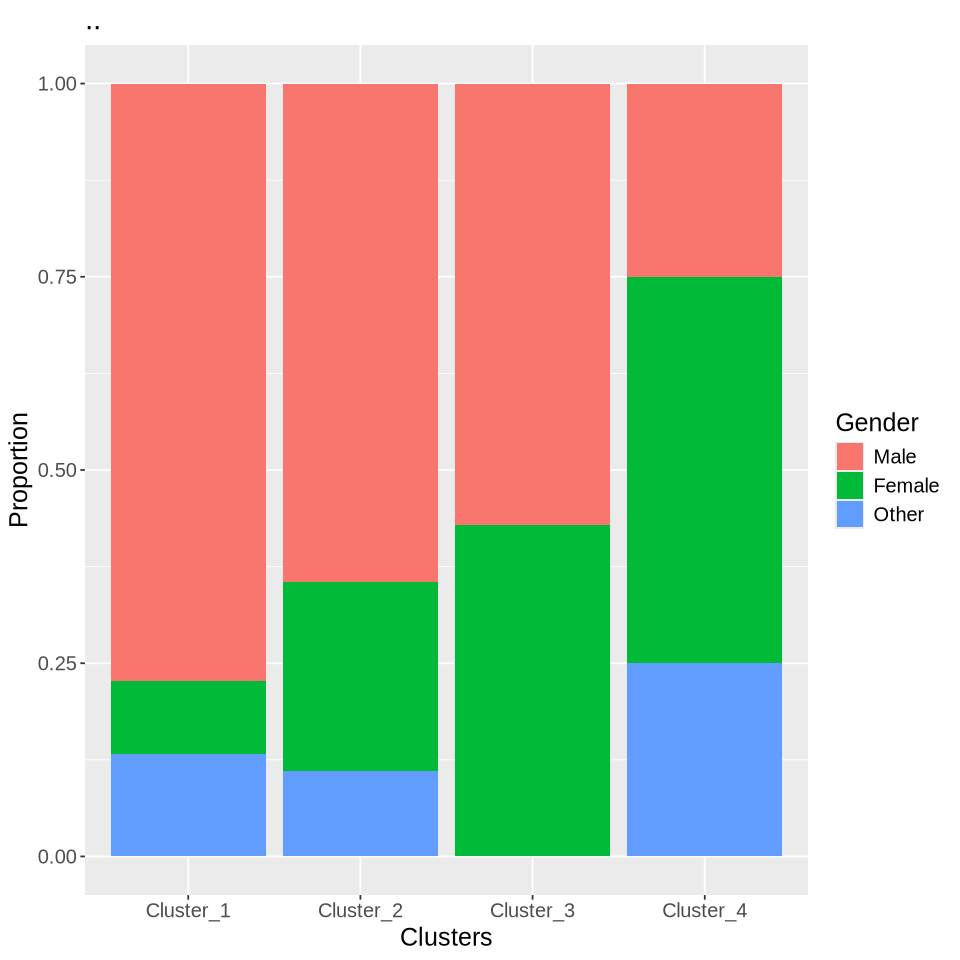

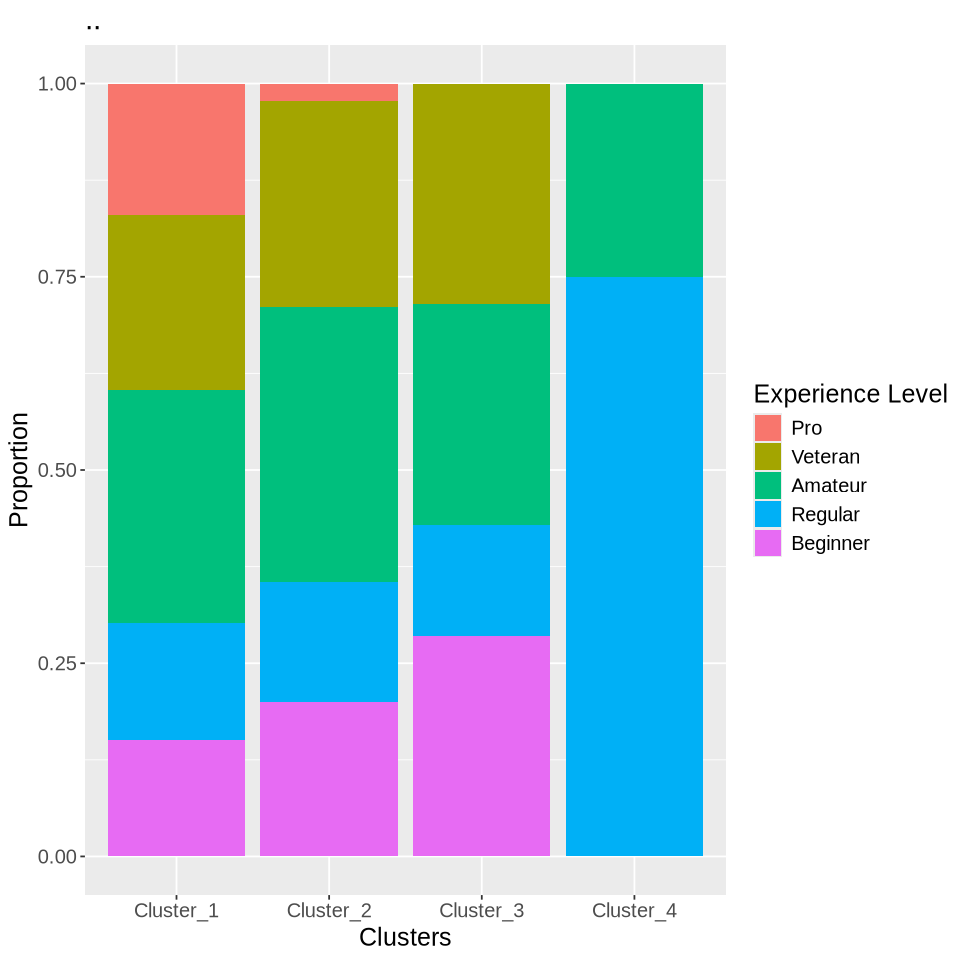

In [145]:
# trying to relate with gender and experience
gender_cluster <- clustered_data |>
  group_by(.pred_cluster, gender) |>
  summarize(count = n())

exp_cluster <- clustered_data |>
  group_by(.pred_cluster, experience) |>
  summarize(count = n())

options(repr.plot.width = 8, repr.plot.height = 8)

gender_cluster_plot <- gender_cluster |>
                    ggplot(aes(x = .pred_cluster, y = count, fill = gender)) +
                    geom_bar(stat = "identity", position = "fill") +
                    labs(x = "Clusters", y = "Proportion",
                         fill = "Gender", title = "..") +
                    theme(text = element_text(size = 15))

gender_cluster_plot

exp_cluster_plot <- exp_cluster |>
                    ggplot(aes(x = .pred_cluster, y = count, fill = experience)) +
                    geom_bar(stat = "identity", position = "fill") +
                    labs(x = "Clusters", y = "Proportion",
                         fill = "Experience Level", title = "..") +
                    theme(text = element_text(size = 15))

exp_cluster_plot